# FFN Signal - No Patient

Author: Jake Dumbauld <br>
Contact: jacobmilodumbauld@gmail.com<br>
Date: 3.15.22

In [1]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
import keras_tuner as kt

In [2]:
import random as python_random

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(42)

#not sure if the below are necessary - leaving in to perhaps un-comment later.
%env PYTHONHASHSEED=0
%env CUDA_VISIBLE_DEVICES=""

env: PYTHONHASHSEED=0
env: CUDA_VISIBLE_DEVICES=""


## Helper Functions

### Model Loss

In [3]:
def graph_model_loss(title, history):
    """
    Description:
    Graphs training vs validation loss over epochs for a given model. 
    
    History: tensorflow.python.keras.callbacks.History object
    Title: str
    """ 
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title,size=24)
    plt.ylabel('Loss',size=16)
    plt.xlabel('Epoch',size=16)
    plt.legend(['Train', 'Validation'])
    plt.show()

### Train/Test Acc Printout

In [4]:
def evaluate_model(model, history):
    """
    Description:
    Outputs model train & test accuracies for currently defined train and test set variables.
    
    model: tensorflow model,
    history: tensorflow.python.keras.callbacks.History object
    """
    # Evaluate the network
    train_accuracy = history.history["binary_accuracy"][-1]
    result = model.evaluate(X_test,y_test, verbose=1)

    print(f"Train Accuracy: {np.round(train_accuracy, 6)*100}%")
    print(f"Test Accuracy: {np.round(result[1], 6)*100}%")

### Defining Hyperparameter Search Space

In [5]:
def build_model(hp):
    model = keras.Sequential()
    #flattening input
    model.add(Flatten())
    
    for i in range(hp.Int('layers', 2, 4)):
        model.add(
            Dense(
            #Tuning the number of units in my input layer.
            units=hp.Int("units" + str(i), min_value=32, max_value=1024, step=64),
            kernel_regularizer=regularizers.l2(0.001),
            activation="relu"
            )
        )
        #Tuning whether or not to use dropout.
        if hp.Boolean("dropout" + str(i)):
            model.add(Dropout(rate=0.25))

        #Adding batch normalization
        if hp.Boolean("normalization" + str(i)):
            model.add(BatchNormalization())

    #output layer
    model.add(Dense(1, activation="sigmoid"))
    
    #defining learning rate
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
                      #tuning initial learning rate
                      initial_learning_rate=hp.Float("starting_learning_rate", min_value=1e-4, max_value=1e-2, sampling="log"),
                      decay_steps=1.0,
                      decay_rate=0.1
                  )
    model.compile(
        #Optimizer
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
        #Loss
        loss=keras.losses.BinaryCrossentropy(),
        #Metrics
        metrics=[keras.metrics.BinaryAccuracy()]
    )
    return model

build_model(kt.HyperParameters())

2022-04-01 11:46:13.340449: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X = np.load('/Users/jmd/Documents/BOOTCAMP/Capstone/arrays/signal_noPatient.npy', allow_pickle=True)
y = np.load('/Users/jmd/Documents/BOOTCAMP/Capstone/arrays/target_array.npy', allow_pickle=True)

In [7]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

In [9]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [10]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=50,
    seed=42,
    overwrite=True,
    directory='/Users/jmd/Documents/BOOTCAMP/Capstone/kerastune_searches',
    project_name='sequential_signal_no_patient'
)

tuner.search(X_train, y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[es_callback])

Trial 50 Complete [00h 00m 03s]
val_loss: 0.553521454334259

Best val_loss So Far: 0.516107439994812
Total elapsed time: 00h 06m 25s
INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary(num_trials=1)

Results summary
Results in /Users/jmd/Documents/BOOTCAMP/Capstone/kerastune_searches/sequential_signal_no_patient
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layers: 4
units0: 32
dropout0: True
normalization0: False
units1: 992
dropout1: False
normalization1: False
starting_learning_rate: 0.01
units2: 32
dropout2: True
normalization2: False
units3: 992
dropout3: True
normalization3: False
Score: 0.516107439994812


In [12]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [13]:
# Get the best hyperparameters.
best_hps = tuner.get_best_hyperparameters()
# Build the model with the best hp.
model = build_model(best_hps[0])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[es_callback])

Epoch 1/100
46/46 [==============================] - 1s 15ms/step - loss: 0.6475 - binary_accuracy: 0.7834 - val_loss: 0.5601 - val_binary_accuracy: 0.7959
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: 0.5390 - binary_accuracy: 0.8044 - val_loss: 0.5311 - val_binary_accuracy: 0.7959
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 0.5288 - binary_accuracy: 0.7935 - val_loss: 0.5319 - val_binary_accuracy: 0.7959
Epoch 4/100
46/46 [==============================] - 0s 9ms/step - loss: 0.4675 - binary_accuracy: 0.7957 - val_loss: 0.6659 - val_binary_accuracy: 0.7959
Epoch 5/100
46/46 [==============================] - 0s 10ms/step - loss: 0.2894 - binary_accuracy: 0.8735 - val_loss: 0.8923 - val_binary_accuracy: 0.7057
Epoch 6/100
46/46 [==============================] - 0s 9ms/step - loss: 0.2330 - binary_accuracy: 0.9624 - val_loss: 1.1022 - val_binary_accuracy: 0.7152
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - l

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                196640    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 992)               32736     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                31776     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 992)              

In [15]:
evaluate_model(model, history)

29/29 [==============================] - 0s 4ms/step - loss: 1.5551 - binary_accuracy: 0.6622
Train Accuracy: 99.4565%
Test Accuracy: 66.2237%


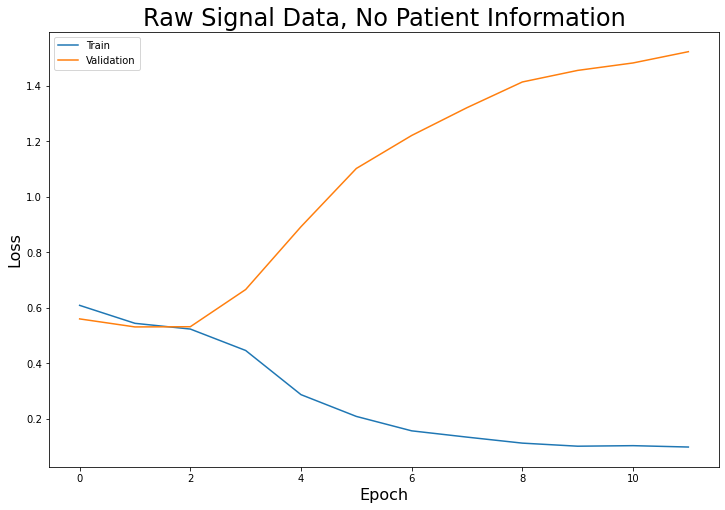

In [16]:
graph_model_loss('Raw Signal Data, No Patient Information', history)

In [18]:
#saving model
model.save('/Users/jmd/Documents/BOOTCAMP/Capstone/neural_nets/sequential_signal_no_patient', overwrite=True)

INFO:tensorflow:Assets written to: /Users/jmd/Documents/BOOTCAMP/Capstone/neural_nets/sequential_signal_no_patient/assets
